# TODO: add header/description

In [1]:
import tensorflow as tf

GPU_MEM_CONFIG = tf.ConfigProto(gpu_options={'allow_growth': True})
seed_file = 'seeds/dnn.csv'
# BigQuery must be enabled for this project
bq_project = 'patent-landscape-165715'
patent_dataset = 'patents-public-data:patents.publications_latest'
num_anti_seed_patents = 15000


In [2]:
from expansion import PatentLandscapeExpander
from word2vec import Word2Vec

expander = PatentLandscapeExpander(
    seed_file,
    bq_project=bq_project,
    patent_dataset=patent_dataset,
    num_antiseed=num_anti_seed_patents)


word2vec5_9m = Word2Vec('5.9m')
w2v_runtime = word2vec5_9m.restore_runtime()

Will use models/5.9m directory to load/persist model information.
INFO:tensorflow:Restoring parameters from models/5.9m/checkpoints/5.9m_abstracts.ckpt-1325000


In [3]:
training_data_full_df, seed_patents_df, l1_patents_df, l2_patents_df, anti_seed_patents = \
    expander.derive_training_data_from_seeds(seed_file)
training_data_full_df.head()

Querying for all US CPC Counts
Querying for Seed Set CPC Counts
Querying to find total number of US patents
Got 16587 relevant seed refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (16587, 1), to patents._l1_tmp
Completed loading temp table.
Shape of L1 expansion: (16457, 3)
Got 137610 relevant L1->L2 refs
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (137610, 1), to patents._l2_tmp
Completed loading temp table.
Shape of L2 expansion: (130899, 3)
Size of union of [Seed, L1, and L2]: 136087
Loading dataframe with cols Index(['pub_num'], dtype='object'), shape (136087, 1), to patents.antiseed_tmp
Completed loading temp table.
Loading training data text from (16553, 2) publication numbers
Loading dataframe with cols Index(['publication_number'], dtype='object'), shape (16553, 1), to patents._tmp_training
Completed loading temp table.
Loading patent texts from provided publication numbers.
Merging labels into training data.


,pub_num,publication_number,family_id,priority_date,title_lang,abstract_lang,claims_lang,description_lang,title_text,abstract_text,claims_text,description_text,ExpansionLevel
0,2014171787,US-2014171787-A1,50884025,20121207,en,en,en,en,Surgical procedure management systems and methods,Systems and methods for tracking a surgical to...,What is claimed is: \n \n 1 . A ...,CROSS-REFERENCE TO RELATED APPLICATION \n ...,AntiSeed
1,2014290597,US-2014290597-A1,51520027,20130328,en,en,en,en,Method for operating a direct fuel injector,"A method, comprising: operating an engine cyli...","1 . A method, comprising:\n operating an engin...",BACKGROUND AND SUMMARY \n [0001] Engi...,AntiSeed
2,2016044408,US-2016044408-A1,55268450,20140805,en,en,en,en,Boundary microphone and boundary microphone ad...,A boundary microphone that can reduce the chan...,What is claimed is: \n \n 1 . A ...,BACKGROUND OF THE INVENTION \n [0001] ...,AntiSeed
3,2016183793,US-2016183793-A1,56162852,20141225,en,en,en,en,Wireless Catheter System for Cardiac Electroph...,A Wireless Catheter Module (WCM) is adapted fo...,1 . A wireless catheter data communication sys...,BACKGROUND \n [0001] 1. Field of the ...,AntiSeed
4,2016341326,US-2016341326-A1,57325274,20150520,en,en,en,en,Liquid container leveler,An apparatus is provided to allow over filling...,What is claimed is: \n \n 1 . An...,FIELD OF THE INVENTION \n [0001] The ...,AntiSeed


In [4]:
#test_embedding = w2v_runtime.load_embedding('test')
w2v_runtime.find_similar('movie', 10)

[{'distance': 0.32779269572446956, 'index': 17523, 'word': 'movies'},
 {'distance': 0.4143014460916512, 'index': 16271, 'word': 'theater'},
 {'distance': 0.45228573856143639, 'index': 8336, 'word': 'photography'},
 {'distance': 0.46586198646042409, 'index': 14299, 'word': 'titles'},
 {'distance': 0.48331811403700065, 'index': 7448, 'word': 'title'},
 {'distance': 0.48399591970497613, 'index': 27391, 'word': 'filmed'},
 {'distance': 0.49104971181473067, 'index': 3912, 'word': 'viewer'},
 {'distance': 0.49438433435760043, 'index': 24883, 'word': 'cinema'},
 {'distance': 0.50278364123260055, 'index': 1859, 'word': 'still'},
 {'distance': 0.51047964928984513, 'index': 2744, 'word': 'playback'}]

In [5]:
print(type(w2v_runtime.embedding_weights))
w2v_runtime.embedding_weights.shape

<class 'numpy.ndarray'>


(110240, 300)

In [6]:
training_df = training_data_full_df[
    ['publication_number', 'title_text', 'abstract_text', 'claims_text', 'description_text', 'ExpansionLevel']]

In [7]:
print(training_df[training_df.ExpansionLevel == 'Seed'].count())
print(training_df[training_df.ExpansionLevel == 'AntiSeed'].count())

publication_number    1484
title_text            1484
abstract_text         1484
claims_text           1484
description_text      1484
ExpansionLevel        1484
dtype: int64
publication_number    10617
title_text            10617
abstract_text         10617
claims_text           10617
description_text      10617
ExpansionLevel        10617
dtype: int64


In [8]:

import tokenizer
tokenizer = tokenizer.TextTokenizer()

def label_text_to_id(label_name):
    if label_name == 'antiseed':
        return 1
    else:
        return 0

def label_id_to_text(label_idx):
    if label_idx == 1:
        return 'antiseed'
    else:
        return 'seed'

def tensor_label_to_text(tensor_text):
    # if element 0 is '1', it means that this is the
    # zeroth label index
    if tensor_text[0] == 1.0:
        return label_id_to_text(0)
    return label_id_to_text(1)

def prediction_to_label(predict_tensor):
    return label_id_to_text(prediction_to_idx(predict_tensor))

def prediction_to_idx(predict_tensor):
    # if element 0 is greater than element 1, it's the label
    if predict_tensor[0] > predict_tensor[1]:
        return 0
    return 1

def to_text(integerized):
    words = []
    for word_int in integerized:
        words.append(w2v_runtime.index_to_word[word_int])
    return ' '.join(words)

def show_details(training_data_series, idx):
    print('\nOriginal: {}\nTokenized: {}\nIntegerized: {}\nLabelIntegerized: {}'.format(
        training_data_series[idx],
        to_text(prepped_train[idx]),
        prepped_train[idx],
        prepped_labels[idx]))

def prep_series_for_training(w2v_runtime, raw_series_text, labels_series):

    tokenized_text = tokenizer.tokenize_series(raw_series_text)
    word_to_index_dict = w2v_runtime.word_to_index
    tokenized_indexed_titles = []
    labels_indexed = []

    for idx in range(0, len(tokenized_text)):
        title = tokenized_text[idx]
        label = labels_series[idx]
        title_word_indexes = []
        for word in title:
            if word in word_to_index_dict:
                word_idx = word_to_index_dict[word]
            else:
                word_idx = word_to_index_dict['UNK']
            # this skips 'the' so it can be used for dynamic rnn
            if word_idx > 0:
                title_word_indexes.append(word_idx)

        tokenized_indexed_titles.append(title_word_indexes)
        tokenized_label = tokenizer.tokenize(label)[0]
        label_idx = label_text_to_id(tokenized_label)
        labels_indexed.append(label_idx)

    return tokenized_indexed_titles, labels_indexed



In [9]:
training_data_series = training_df.abstract_text

prepped_train, prepped_labels = \
    prep_series_for_training(w2v_runtime, training_data_series, training_df.ExpansionLevel)

print('Num documents: {}, num tokenized docs: {}, num labels: {}'.format(
    training_df.shape, len(prepped_train), len(prepped_labels)))


Num documents: (12101, 6), num tokenized docs: 12101, num labels: 12101


In [10]:
show_details(training_data_series, 0)
#show_details(training_data_series, 4)
#show_details(training_data_series, 400)
#show_details(training_data_series, 16)


Original: Systems and methods for tracking a surgical tool. Exemplary embodiments can comprise a surgical port, a tracking element configured for coupling to a surgical tool, and a camera mounted to a proximal end of the surgical port and configured to capture image data associated with the tracking element.
Tokenized: systems and methods for tracking a surgical tool exemplary embodiments can comprise a surgical port a tracking element configured for coupling to a surgical tool and a camera mounted to a proximal end of surgical port and configured to capture image data associated with tracking element
Integerized: [326, 3, 155, 9, 1605, 1, 1782, 344, 2129, 418, 38, 771, 1, 1782, 421, 1, 1605, 73, 151, 9, 414, 4, 1, 1782, 344, 3, 1, 778, 122, 4, 1, 1401, 44, 2, 1782, 421, 3, 151, 4, 2031, 59, 29, 170, 10, 1605, 73]
LabelIntegerized: 1


In [11]:
import random

def randomize_training(train_arr, label_arr, percent_train):
    training_data_to_shuffle = list(zip(train_arr, label_arr))
    random.shuffle(training_data_to_shuffle)
    train_arr, label_arr = zip(*training_data_to_shuffle)

    train_idx = int(len(train_arr) * percent_train)

    trainX = train_arr[:train_idx]
    testX = train_arr[train_idx:]

    trainY = label_arr[:train_idx]
    testY = label_arr[train_idx:]

    return trainX, testX, trainY, testY

trainX, testX, trainY, testY = randomize_training(prepped_train, prepped_labels, 0.8)


In [12]:
print_idx = 0
for row in trainY:
    if trainY[print_idx] == 0:
        break
    else:
        print_idx += 1

print('Using index {}.'.format(print_idx))
print(trainX[print_idx])
print(to_text(trainX[print_idx]))
print(trainY[print_idx])

Using index 1.
[1, 27, 3, 30, 9, 364, 7666, 1107, 12, 196, 676, 2409, 13, 90, 9521, 309, 21, 190, 5, 1, 30, 78, 2508, 88, 17, 8, 348, 72, 27, 2508, 119, 17, 348, 72, 27, 364, 1, 3233, 119, 91, 245, 6151, 88, 1536, 3233, 119, 10, 6151, 119, 3, 364, 1, 3770, 119, 172, 89, 1, 47, 2, 3253, 347, 52, 3233, 119, 10847, 10, 6151, 119]
a system and method for determining harmonics caused by non linear loads are disclosed briefly described one embodiment is a method comprising metering voltage on an electric power system metering current on electric power system determining a predicted current based upon metered voltage comparing predicted current with metered current and determining a harmonic current component using a plurality of weights determined when predicted current converges with metered current
0


# Train LSTM Using Embeddings

In [13]:
import numpy as np

trainX, testX = np.array(trainX), np.array(testX)
trainY, testY = np.array(trainY), np.array(testY)

In [14]:
print('training data shape: {}, train labels shape: {}'.format(trainX.shape, trainY.shape))
print('test data shape: {}, test labels shape: {}'.format(testX.shape, testY.shape))

doc_lengths = list(map(len, trainX))
median_doc_length = int(np.median(doc_lengths))
print('median doc length: {}'.format(median_doc_length))
print('mean doc length: {}'.format(np.mean(doc_lengths)))
print('max doc length: {}'.format(np.max(doc_lengths)))


training data shape: (9680,), train labels shape: (9680,)
test data shape: (2421,), test labels shape: (2421,)
median doc length: 104
mean doc length: 105.51673553719009
max doc length: 819


In [15]:
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences

# Data preprocessing
# Sequence padding

sequence_len = median_doc_length + 10

unk_idx = w2v_runtime.word_to_index['UNK']
mask_idx = unk_idx#0 # 'the'

trainX = pad_sequences(trainX, maxlen=sequence_len, value=mask_idx)
testX = pad_sequences(testX, maxlen=sequence_len, value=mask_idx)
# Converting labels to binary vectors
trainY = to_categorical(trainY, nb_classes=2)
testY = to_categorical(testY, nb_classes=2)


In [16]:
trainX[print_idx]

array([     1,     27,      3,     30,      9,    364,   7666,   1107,
           12,    196,    676,   2409,     13,     90,   9521,    309,
           21,    190,      5,      1,     30,     78,   2508,     88,
           17,      8,    348,     72,     27,   2508,    119,     17,
          348,     72,     27,    364,      1,   3233,    119,     91,
          245,   6151,     88,   1536,   3233,    119,     10,   6151,
          119,      3,    364,      1,   3770,    119,    172,     89,
            1,     47,      2,   3253,    347,     52,   3233,    119,
        10847,     10,   6151,    119, 110239, 110239, 110239, 110239,
       110239, 110239, 110239, 110239, 110239, 110239, 110239, 110239,
       110239, 110239, 110239, 110239, 110239, 110239, 110239, 110239,
       110239, 110239, 110239, 110239, 110239, 110239, 110239, 110239,
       110239, 110239, 110239, 110239, 110239, 110239, 110239, 110239,
       110239, 110239, 110239, 110239, 110239, 110239, 110239, 110239,
      

In [17]:
print(w2v_runtime.normed_embedding_weights[0][:10])
print(w2v_runtime.embedding_weights[0][:10])

[-0.02672337 -0.0415425   0.04715231 -0.02182292 -0.04397739  0.00257788
  0.01632516  0.00512346  0.02428765  0.03930404]
[-0.08050653 -0.1251505   0.14205055 -0.0657435  -0.13248584  0.00776609
  0.04918102  0.01543488  0.07316872  0.11840695]


In [27]:
def build_landscape_lstm(
    sequence_length,
    vocab_size,
    embedding_size,
    dropout=0.8,
    learn_rate=0.001,
    tboard_verbosity=0,
    pretrained_embedding_weights=None):

    if pretrained_embedding_weights is None:
        raise Exception('must specify pretrained embedding weights')

    # Network building
    net = tflearn.input_data([None, sequence_length])
    print('Shape of input tensor: {}'.format(net.shape))
    # TODO: consider not requiring pretrained embedding weights
    net = tflearn.embedding(
        net,
        input_dim=int(vocab_size),
        output_dim=int(embedding_size),
        trainable=False,
        name="EmbeddingLayer")
    #net = tflearn.embedding(net, input_dim=vocab_size, output_dim=128)
    print('Shape of embedding tensor: {}'.format(net.shape))
    net = tflearn.lstm(
        incoming=net,
        n_units=int(embedding_size),
        dropout=dropout,
        dynamic=True,
        return_seq=False)
    print('Shape of 1st LSTM tensor: {}'.format(net.shape))

    net = tflearn.fully_connected(net, int(embedding_size/2), activation='elu')
    print('Shape of 1st FC tensor: {}'.format(net.shape))

    net = tflearn.layers.normalization.batch_normalization(net)
    print('Shape of BatchNorm tensor: {}'.format(net.shape))

    net = tflearn.fully_connected(net, 2, activation='softmax')
    print('Shape of output FC tensor: {}'.format(net.shape))

    net = tflearn.regression(net,
                             optimizer='adam',
                             learning_rate=learn_rate,
                             loss='categorical_crossentropy')

    print('Shape of regression tensor: {}'.format(net.shape))
    print('Created network.')

    # Training
    model = tflearn.DNN(net, tensorboard_verbose=tboard_verbosity)
    print('Created model graph.')

    # Retrieve embedding layer weights (only a single weight matrix, so index is 0)
    print('Inserting word2vec word embeddings')
    embeddingWeights = tflearn.get_layer_variables_by_name('EmbeddingLayer')[0]
    # Assign your own weights (for example, a numpy array [input_dim, output_dim])
    model.set_weights(embeddingWeights, pretrained_embedding_weights)
    print('Model ready for training.')
    return model


In [28]:
vocab_size = w2v_runtime.embedding_weights.shape[0]
embedding_size = w2v_runtime.embedding_weights.shape[1]
print('Vocab size: {}'.format(vocab_size))
print('Embedding size: {}'.format(embedding_size))

tf.reset_default_graph()

with tf.Graph().as_default():
    model = build_landscape_lstm(
        sequence_length=sequence_len,
        vocab_size=vocab_size,
        embedding_size=embedding_size,
        dropout=0.75,
        learn_rate=0.01,
        tboard_verbosity=3,
        pretrained_embedding_weights=w2v_runtime.embedding_weights
    )


Vocab size: 110240
Embedding size: 300
Shape of input tensor: (?, 114)
Shape of embedding tensor: (?, 114, 300)
Shape of 1st LSTM tensor: (?, 300)
Shape of 1st FC tensor: (?, 150)
Shape of BatchNorm tensor: (?, 150)
Shape of output FC tensor: (?, 2)
Shape of regression tensor: (?, 2)
Created network.


/usr/local/google/home/feltenberger/anaconda3/envs/pl35/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Created model graph.
Inserting word2vec word embeddings
Model ready for training.


In [29]:
print('Training LSTM')
with tf.Graph().as_default():
    model.fit(
        trainX,
        trainY,
        validation_set=(testX, testY),
        show_metric=True,
        batch_size=32,
        n_epoch=50)


Training LSTM
---------------------------------
Run id: 9R3MMU
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 9680
Validation samples: 2421
--


ValueError: Operation 'LSTM/LSTM/cond/Assign' has been marked as not fetchable.

In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def predictions_for_report(patent_model, validX, validY):
    target_names = ['seed', 'antiseed']

    prediction_scores = patent_model.predict(validX)
    predictions = []
    actual_y = []

    for idx in range(0, len(prediction_scores)):
        prediction = prediction_scores[idx]
        actual = validY[idx]
        predictions.append(prediction_to_idx(prediction))
        actual_y.append(prediction_to_idx(actual))

    return predictions, actual_y, target_names

predictions, actual_y, target_names = predictions_for_report(model, testX, testY)
cr = classification_report(predictions, actual_y, target_names=target_names)
cm = confusion_matrix(predictions, actual_y)
print(cr)
print(cm)

             precision    recall  f1-score   support

       seed       0.66      0.96      0.78       208
   antiseed       1.00      0.95      0.97      2231

avg / total       0.97      0.95      0.96      2439

[[ 199    9]
 [ 104 2127]]


# Inference!

In [40]:
#training_df[training_df.abstract_text.str.contains('learn') & training_df.abstract_text.str.contains('machine')]

#training_df[training_df.abstract_text.str.contains('machine')]
l2_texts = expander.load_training_data_from_pubs(l2_patents_df[['publication_number']])
l2_texts['label'] = 'Seed'
l2_texts.head()

,pub_num,publication_number,family_id,priority_date,title_lang,abstract_lang,claims_lang,description_lang,title_text,abstract_text,claims_text,description_text,label
0,5546456,US-5546456-A,23091784,19940802,en,en,en,en,Telecommunication system with inbound call res...,A telecommunication system (10) having an auto...,We claim: \n \n 1. A telecommunica...,This application is a continuation of applicat...,Seed
1,5252489,US-5252489-A,25452087,19890117,en,en,en,en,Down syndrome screening method utilizing dried...,The present invention relates to a method for ...,I claim: \n \n 1. A screening meth...,This application is a continuation-in-part of ...,Seed
2,7818270,US-7818270-B2,36692900,20050118,en,en,en,en,Method and system for tracking and budgeting e...,An energy tracking and reporting system can re...,1. A method of budgeting future energy consump...,RELATED APPLICATIONS \n This application c...,Seed
3,2015112911,US-2015112911-A1,52827087,20131021,en,en,en,en,Coupling parallel event-driven computation wit...,The present invention provides a system compri...,What is claimed is: \n \n 1 . A ...,[0001] This invention was made with Governm...,Seed
4,2002087532,US-2002087532-A1,22981932,20001229,en,en,en,en,"Cooperative, interactive, heuristic system for...",An Internet-related invention comprising hardw...,What is claimed is: \n \n 1 . A...,RELATED CASE \n [0001] This Applicat...,Seed


In [89]:
import pandas as pd
l1_texts_subset = l1_texts.abstract_text[:10000]
l1_texts_subset.reset_index(drop=True, inplace=True)
l1_texts_subset.loc[len(l1_texts_subset)-1] = 'this abstract is about something entirely boring'

l1_labels_subset = l1_texts.label[:10000]
l1_labels_subset.reset_index(drop=True, inplace=True)
l1_labels_subset.loc[len(l1_texts_subset)-1] = 'AntiSeed'

l1_x, l1_y = prep_series_for_training(w2v_runtime, l1_texts_subset, l1_labels_subset)
l1_x = np.array(l1_x)
l1_y = np.array(l1_y)


# Convert text idx into padded sequences
l1_x = pad_sequences(l1_x, maxlen=sequence_len, value=mask_idx)
# Converting labels to binary vectors
l1_y = to_categorical(l1_y, nb_classes=2)

l1_preds, actual_l1_y, target_names = predictions_for_report(model, l1_x, l1_y)

cr = classification_report(l1_preds, actual_l1_y, target_names=target_names)
cm = confusion_matrix(l1_preds, actual_l1_y)
print(cr)
print(cm)
#l1_texts_subset

             precision    recall  f1-score   support

       seed       0.20      1.00      0.33      2009
   antiseed       1.00      0.00      0.00      7991

avg / total       0.84      0.20      0.07     10000

[[2009    0]
 [7990    1]]


In [120]:
#print(l1_preds)
l1_preds_df = pd.DataFrame(l1_preds, columns=['PredictionIdx'])
l1_preds_df['Prediction'] = l1_preds_df.PredictionIdx.apply(label_id_to_text)
l1_preds_df

,PredictionIdx,Prediction
0,1,antiseed
1,1,antiseed
2,1,antiseed
3,0,seed
4,1,antiseed
5,1,antiseed
6,1,antiseed
7,1,antiseed
8,1,antiseed
9,1,antiseed


In [114]:
l1_texts_subset[1]

'The present invention relates to a method for detecting fetal Down syndrome (Trisomy 21), trisomy 13, trisomy 18 and other chromosomal anomalies during prenatal screening by analyzing a dried blood sample from a pregnant woman. More particularly the present invention relates to a method for improving detection efficiency in screening for the anomalies by measuring the amount of the free beta human chorionic gonadotropin (HCG) and nicked or fragmented or aberrant forms of free beta (HCG), all of which are referenced throughout this application as free beta (HCG) in dried blood samples from pregnant women.'

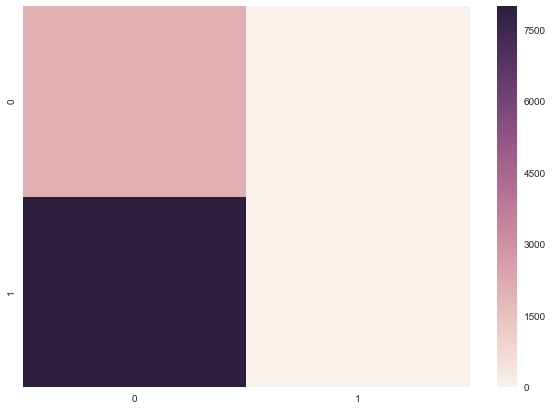

In [93]:
%matplotlib inline

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm_df = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sn.heatmap(cm_df)

In [100]:
import pandas as pd

def make_prediction(patent_model, text, expected_label, max_seq_len, mask_idx):
    inf_series = pd.Series([text])
    lab_series = pd.Series([label])

    prepped_train, prepped_labels = \
        prep_series_for_training(
            w2v_runtime=w2v_runtime,
            labels_series=lab_series,
            raw_series_text=inf_series)

    # make sure we have the correct sequence length
    infX = pad_sequences(prepped_train, maxlen=max_seq_len, value=mask_idx)

    # actually make prediction
    prediction = patent_model.predict(infX)[0]

    return prediction


In [127]:
text = l1_texts_subset[10]#'a neurosynaptic processing device including multiple core circuits for parallel processing, and a serial processing device including at least one processor core for serial processing. Each core circuit comprises multiple electronic neurons interconnected with multiple electronic axons via a plurality of synapse devices. The system further comprises an interconnect circuit for coupling the processing device with the serial processing device. The interconnect circuit enables the exchange of data packets between the neurosynaptic processing device and the serial processing device'
label = 'Seed'
prediction = make_prediction(model, text, expected_label=label, max_seq_len=sequence_len, mask_idx=mask_idx)
print('Text: {}'.format(text))
#print('Tokenized/Integerized: {}'.format(prepped_train))
#print('Padded: {}'.format(infX))
print('Prediction: {}'.format(prediction))
print('Predicted Label: {}, Actual Label: {}'.format(prediction_to_label(prediction), label))


Text: Disclosed is a means and method for placing an implantable neurostimulator control module into a place in the cranium where cranial bone has been removed. The method for accomplishing this cranial implantation is by first removing a patient&#39;s hair over the site of the implant, then cutting the scalp at that site and pulling it back to expose the cranium. A neurosurgeon would then remove a portion of the cranial bone to accept a control module to be implanted within that hole. The control module would then be placed into that hole. It is also conceived that the control module would be fixed in place by the use of one or more attachment devices such as a multiplicity of bone screws placed through holes in one or more flanges that extend over the cranium beyond the control module. The implantation could also include a fairing placed around the control module to provide a smooth contour under the patient&#39;s scalp. Also described is a spacer shim placed under the flange(s) to a

In [302]:
#oldidx = print_idx
#print_idx = oldidx
#print(model.predict([trainX[print_idx]]))
#tensor_label_to_text(trainY[print_idx])